## Non-holonomic RRT 

In [1]:
import matplotlib.pyplot as plt
import random as rd
import math
import numpy as np
import os, re, os.path

In [2]:
class nonhn_RRT:
    def __init__(self,
                 start_config,
                 goal,
                 v_init,
                 w_init,
                 n_obs,
                 n_circ,
                 n_rect,
                 c_center_x,
                 c_center_y,
                 c_radius,
                 rect_x ,
                 rect_y,
                 xMax,
                 yMax):
        (x0,y0,theta0) = start_config
        self.xg = goal[0]
        self.yg = goal[1]
        self.x = []
        self.y = []
        self.theta = []
        self.x.append(x0)
        self.y.append(y0)
        self.theta.append(theta0)
        self.vc = [] #platform centre v list
        self.wc = [] #platform centre w list
        self.vc.append(v_init)
        self.wc.append(w_init)
        self.init_link = []
        self.init_link.append(0)
        #For Obstacles
        self.n_obs = n_obs
        self.n_circ = n_circ
        self.n_rect = n_rect
        self.c_center_x = c_center_x
        self.c_center_y = c_center_y
        self.c_radius = c_radius
        self.rect_x = rect_x
        self.rect_y = rect_y
        self.xMax = xMax
        self.yMax = yMax
        self.way = []
        
        
    # implement non-holonomic RRT to find platform centre velocities
    def clearFiles(self,folder):
        mypath = folder
        for root, dirs, files in os.walk(mypath):
            for file in files:
                os.remove(os.path.join(root, file))
        
    def findDist(self,param1,param2):
        return (((self.x[param1]-self.x[param2])**2 + (self.y[param1]-self.y[param2])**2)**0.5) 
        
        
    #Expand_nh
    def grow(self):
        (x,y,theta) = rd.uniform (0,100),rd.uniform (0,100),rd.uniform(-math.pi, math.pi)
        node = len(self.x) 
        self.x.insert(node, x)
        self.y.insert(node, y)
        self.theta.insert(node,theta)
        self.vc.insert(node, 0)
        self.wc.insert(node, 0)
        init_dist = self.findDist(node,0)
        close_node = 0
        for i in range(0,node):
            if self.findDist(i,node) < init_dist:
                close_node = i
                init_dist =self.findDist(i,node)
        final_pos,final_con = self.RRT_Implement(close_node,node)
        if 0<=final_pos[0]<=100 and 0<=final_pos[1]<=100:
            self.x.pop(node)
            self.y.pop(node)
            self.theta.pop(node)
            self.vc.pop(node)
            self.wc.pop(node)
            self.x.insert(node, final_pos[0])
            self.y.insert(node, final_pos[1])
            self.theta.insert(node,final_pos[2])
            self.vc.insert(node, final_con[0])
            self.wc.insert(node, final_con[1])
            if self.collisionNode()!=False:
                #Go to the next node
                self.nextNode(close_node,node,final_pos[2],final_con)
                if self.collisionEdge(self.x[close_node],self.y[close_node],self.x[node],self.y[node]) == False:
                    self.x.pop(node)
                    self.y.pop(node)
                    self.theta.pop(node)
                    self.vc.pop(node)
                    self.wc.pop(node)
                else:
                    self.init_link.insert(node,close_node)
        else:
            self.x.pop(node)
            self.y.pop(node)
            self.theta.pop(node)
            self.vc.pop(node)
            self.wc.pop(node)
    
    
    
    
    def nextNode(self,close_node,node,theta,arr_con):
        init = 10
        if self.findDist(close_node,node)>init:
            newT = self.theta[close_node] + arr_con[1]*dt
            newX = self.x[close_node] + arr_con[0]*dt*math.cos(newT)
            newY = self.y[close_node] + arr_con[0]*dt*math.sin(newT)
            #Delete old node
            self.x.pop(node)
            self.y.pop(node)
            self.theta.pop(node)
            self.vc.pop(node)
            self.wc.pop(node)
            #Insert modified node
            self.x.insert(node, newX)
            self.y.insert(node, newY)
            self.theta.insert(node,theta)
            self.vc.insert(node, arr_con[0])
            self.wc.insert(node, arr_con[1])
    
    
    def collisionNode(self):
        #Check for rectangle)
        maxIter = len(self.x)-1
        x = self.x[maxIter]
        y = self.y[maxIter]
        for i in range(1,self.n_rect+1):
            x_l = self.rect_x[4*(i-1)]
            x_r = self.rect_x[4*(i-1)+2]
            y_b = self.rect_y[4*(i-1)]
            y_t = self.rect_y[4*(i-1)+2]
            if x_l<=x<=x_r and y_b<=y<=y_t: 
                self.x.pop(maxIter)
                self.y.pop(maxIter)
                self.theta.pop(maxIter)
                self.vc.pop(maxIter)
                self.wc.pop(maxIter)
                return False
        #Check for circle
        for i in range(self.n_circ):
            x_c = self.c_center_x[i]
            y_c = self.c_center_y[i]
            rad = self.c_radius[i]
            dist_c = ((x-x_c)**2 + (y-y_c)**2)**0.5
            if dist_c<=rad: 
                self.x.pop(maxIter)
                self.y.pop(maxIter)
                self.theta.pop(maxIter)
                self.vc.pop(maxIter)
                self.wc.pop(maxIter)
                return False         
        return True
    
    def RRT_Implement(self,close_node,node):
        initial_pos = np.array([self.x[close_node],self.y[close_node],self.theta[close_node]])
        final_pos = np.array([self.x[node],self.y[node],self.theta[node]])
        move = []
        #High Velocity Movement
        move.append((10,-math.pi/9))
        move.append((10,math.pi/9))
        move.append((10,0))
         #Medium Velocity movement
        move.append((5,-math.pi/9))
        move.append((5,math.pi/9))
        move.append((5,0))
        #Low velocity movement -20,0,20 degree movement
        move.append((1,-math.pi/9))
        move.append((1,math.pi/9))
        move.append((1,0))
        
        dMax = 1e7+7
        actual_pos = [0,0,0]
        actual_con = [0,0]
        #Iterate through possible controls
        for i in range(len(move)):
            xnew = initial_pos[0] + move[i][0]*dt*math.cos(initial_pos[2] + move[i][1]*dt)
            ynew = initial_pos[1] + move[i][0]*dt*math.sin(initial_pos[2] + move[i][1]*dt)
            d_c_g = np.linalg.norm(np.array([final_pos[0],final_pos[1]])-np.array([xnew,ynew])) 
            if d_c_g < dMax:
                actual_pos[0] = xnew
                actual_pos[1] = ynew
                actual_pos[2] = initial_pos[2] + move[i][1]*dt
                actual_con[0] = move[i][0]
                actual_con[1] = move[i][1]
                dMax = d_c_g
        return actual_pos,actual_con
    
    
    def collisionEdge(self,x1,y1,x2,y2):
        #Check for rectangle
        n = len(self.x)-1
        subDiv = 100
        for i in range(1,self.n_rect+1):
            x_l = self.rect_x[4*(i-1)]
            x_r = self.rect_x[4*(i-1)+2]
            y_b = self.rect_y[4*(i-1)]
            y_t = self.rect_y[4*(i-1)+2]
            for j in range(0,subDiv+1):
                sDiv= j/subDiv
                valX = x1*sDiv + x2*(1-sDiv)
                valY = y1*sDiv + y2*(1-sDiv)
                if x_l<=valX<=x_r and y_b<=valY<=y_t:
                    return False
        #Check for circle
        for i in range(self.n_circ):
            x_c = self.c_center_x[i]
            y_c = self.c_center_y[i]
            rad = self.c_radius[i]
            for j in range(0,subDiv+1):
                sDiv= j/subDiv
                valX = x1*sDiv + x2*(1-sDiv)
                valY = y1*sDiv + y2*(1-sDiv)
                dist_c = ((valX-x_c)**2 + (valY-y_c)**2)**0.5
                if dist_c<=rad: 
                    return False   
        return True
    
        
    def reached(self):
        end_pos  = np.array([self.x[len(self.x)-1],self.y[len(self.y)-1]])
        goal_pos = np.array([self.xg,self.yg])
        diff_pos = end_pos - goal_pos
        dist_pos_goal = np.linalg.norm(diff_pos**2)
        if dist_pos_goal<4:
            return True
        return False
 
    def wayGoal(self):
    #find goal state
        way_goal = []
        actual = 0
        #Iterate past nodes:
        for i in range(0,len(self.x)):
            curr_pos = np.array([self.x[i],self.y[i]])
            goal_pos = np.array([self.xg,self.yg])
            diff_pos = curr_pos - goal_pos
            dist_curr_goal = np.linalg.norm(diff_pos**2)
            if dist_curr_goal<4:
                break
        #Now find path to goal_link
        way_goal.append(i)
        pre_goal_link = self.init_link[i]
        while(pre_goal_link!=0):
            way_goal.append(pre_goal_link)
            pre_goal_link = self.init_link[pre_goal_link]
        way_goal.append(0)
        self.way = way_goal



    def showpath(self):
        """
        Create a new directory (say nonholonomic_path) and save snapshots of the robot moving along the
        trajectory found by RRT at every step with the step index.
        e.g: snap1.png, snap2.png ...
        """
        isExist = os.path.exists("nonholonomic_path")
        if not isExist:

          # Create a new directory because it does not exist 
            os.makedirs("nonholonomic_path")
            print("The new directory is created!")
        self.clearFiles("nonholonomic_path")

        n = len(self.way)-1
        pp = 0
        for i in range (0,len(self.x)):
            par=self.init_link[i]
            plt.plot([self.x[i],self.x[par]],[self.y[i],self.y[par]],color='black')
        for i in range (n):
            start = self.way[-i-1]
            end = self.way[-i-2]
            centre_v.append((self.vc[self.way[n-i-1]]))
            w_list.append((self.wc[self.way[n-i-1]]))
            
            
            obst_vertex_x = [30, 30,50, 50, 
                         70, 70, 80, 80,  
                         40, 40, 60, 60,
                         40, 40, 60, 60, 
                         10, 10, 20, 20, 
                         60, 60, 80, 80] 
            obst_vertex_y = [72,  90,  90, 72, 
                             40,  60,  60, 40,
                             50,  60,  60, 50,
                              0,  28,  28,  0,
                             60,  75,  75, 60,
                             95, 100, 100, 95]
            plt.plot(self.xg,self.yg,'g*',markersize=20)
            plt.plot(self.x[0],self.y[0],'b*',markersize=20)
            for j in range(1,self.n_rect+1): 
                x = obst_vertex_x[4*(j-1)]
                y = obst_vertex_y[4*(j-1)]
                width  = obst_vertex_x[4*(j-1)+2] - obst_vertex_x[4*(j-1)]
                height = obst_vertex_y[4*(j-1)+2] - obst_vertex_y[4*(j-1)]
                rect = plt.Rectangle((x,y),width,height,linewidth=1,color='r')
                plt.gca().add_patch(rect)

            circle_x = self.c_center_x
            circle_y = self.c_center_y
            radii = self.c_radius-np.full((self.n_circ), length)

            for j in range(self.n_circ): #plotting  circles
                circle = plt.Circle((circle_x[j],circle_y[j]),radii[j], color='r')
                plt.gca().add_patch(circle)
            
            way_x = np.array([self.x[start],self.x[end]])
            way_y = np.array([self.y[start],self.y[end]])
            plt.plot(way_x,way_y)

            for j in range (i):
                start = self.way[-j-1]
                end = self.way[-j-2]
                way_x = np.array([self.x[start],self.x[end]])
                way_y = np.array([self.y[start],self.y[end]])
                plt.plot(way_x,way_y)
            plt.gca().set_aspect('equal', adjustable='box')
            name = f'nonholonomic_path/snap{str(pp)}.png'
            plt.savefig(name,dpi=250)
            pp+=1
        plt.show()
            
        

        
    def showtree(self):
        """
        Create a new directory (say nonholonomic_tree) and save snapshots of the evolution of the RRT tree
        at every step with the step index.
        e.g: snap1.png, snap2.png ...
        """
        isExist = os.path.exists("nonholonomic_tree")
        if not isExist:

          # Create a new directory because it does not exist 
            os.makedirs("nonholonomic_tree")
            print("The new directory is created!")
        self.clearFiles("nonholonomic_tree")
        
        
        node_num = 0
        obst_vertex_x = [30, 30,50, 50, 
                         70, 70, 80, 80,  
                         40, 40, 60, 60,
                         40, 40, 60, 60, 
                         10, 10, 20, 20, 
                         60, 60, 80, 80] 
        obst_vertex_y = [72,  90,  90, 72, 
                         40,  60,  60, 40,
                         50,  60,  60, 50,
                          0,  28,  28,  0,
                         60,  75,  75, 60,
                         95, 100, 100, 95]
        plt.plot(self.xg,self.yg,'g*',markersize=20)
        plt.plot(self.x[0],self.y[0],'b*',markersize=20)
        for j in range(1,self.n_rect+1): 
            x = obst_vertex_x[4*(j-1)]
            y = obst_vertex_y[4*(j-1)]
            width  = obst_vertex_x[4*(j-1)+2] - obst_vertex_x[4*(j-1)]
            height = obst_vertex_y[4*(j-1)+2] - obst_vertex_y[4*(j-1)]
            rect = plt.Rectangle((x,y),width,height,linewidth=1,color='r')
            plt.gca().add_patch(rect)
            
        circle_x = self.c_center_x
        circle_y = self.c_center_y
        radii = self.c_radius-np.full((self.n_circ), length)
        # print("Circle")
        for j in range(self.n_circ): 
            circle = plt.Circle((circle_x[j],circle_y[j]),radii[j], color='r')
            plt.gca().add_patch(circle)
        # print("FINAL")
        pp = 0
        for j in range (0,len(self.x)):
            par=self.init_link[j]
            plt.plot([self.x[j],self.x[par]],[self.y[j],self.y[par]],color='black')
            plt.gca().set_aspect('equal', adjustable='box')
            if j%50==0:
                name = f'nonholonomic_tree/snap{str(pp)}.png'
                plt.savefig(name,dpi=250)
                pp+=1
        name = f'nonholonomic_tree/snap{str(pp)}.png'
        plt.savefig(name,dpi=250)
        plt.show()
    
        
    def test_env(self):
        """
        Function to generate test environment
        """
        # the vertices for each obstacle are given in the clockwise order starting from lower left
        obst_vertex_x = [30, 30,50, 50, 
                         70, 70, 80, 80,  
                         40, 40, 60, 60,
                         40, 40, 60, 60, 
                         10, 10, 20, 20, 
                         60, 60, 80, 80] 
        obst_vertex_y = [72,  90,  90, 72, 
                         40,  60,  60, 40,
                         50,  60,  60, 50,
                          0,  28,  28,  0,
                         60,  75,  75, 60,
                         95, 100, 100, 95]
        plt.plot(self.xg,self.yg,'g*',markersize=20)
        plt.plot(self.x[0],self.y[0],'b*',markersize=20)
        for i in range(1,self.n_rect+1): 
            x = obst_vertex_x[4*(i-1)]
            y = obst_vertex_y[4*(i-1)]
            width = obst_vertex_x[4*(i-1)+2] - obst_vertex_x[4*(i-1)]
            height = obst_vertex_y[4*(i-1)+2] - obst_vertex_y[4*(i-1)]
            rect = plt.Rectangle((x,y),width,height,linewidth=1,color='r')
            plt.gca().add_patch(rect)
           
        #centre positions of circular obstacles
        circle_x = self.c_center_x
        circle_y = self.c_center_y
        radii = self.c_radius-np.full((self.n_circ), length)

        for i in range(self.n_circ): #plotting  circles
            circle = plt.Circle((circle_x[i],circle_y[i]),radii[i], color='r')
            plt.gca().add_patch(circle)

        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

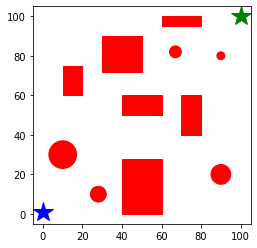

In [3]:
goal = (100,100)
start_config =(0,1,0)
vinit = 5
winit = 0.1
dmax = 10
length = 4#One unit each side
dt = 1

obs_rect_x = [30-length,
              30-length,
              50+length,
              50+length,
              70-length,
              70-length,
              80+length,
              80+length,
              40-length,
              40-length,
              60+length,
              60+length,
              40-length,
              40-length,
              60+length,
              60+length,
              10-length,
              10-length,
              20+length,
              20+length,
              60-length,
              60-length,
              80+length,
              80+length]
obs_rect_y =[72-length, 90-length, 90+length, 72+length,
             40-length, 60-length,60+length,40+length, 
             50-length, 60-length,60+length,50+length,
              0-length, 28-length, 28+length, 0+length,
             60-length, 75-length,75+length, 60+length,
             95-length, 95-length, 100+length,100+length]

nn_RRT = nonhn_RRT(start_config,goal,vinit,winit,
                 n_obs = 11,
                 n_circ = 5,
                 n_rect = 6,
                 c_center_x = [10, 90, 67, 90, 28],
                 c_center_y = [30, 80, 82, 20, 10],
                 c_radius = [7+length, 2+length, 3+length, 5+length,4+length],
                 rect_x = obs_rect_x ,
                 rect_y = obs_rect_y,
                 xMax = 100,
                 yMax = 100)
nn_RRT.test_env()

In [4]:
centre_v = []
lw_v = []
w_list = []
rw_v = []

In [5]:
s = 0
i = 0
while s==0:
        if i%100 ==0:
            print(i)
        i+=1
        nn_RRT.grow()
        if nn_RRT.reached()==True:
            print("DONE")
            break

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
DONE


The new directory is created!


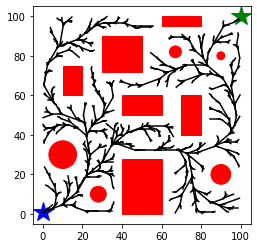

In [6]:
nn_RRT.showtree()

In [7]:
nn_RRT.wayGoal()

In [8]:
nn_RRT.way,len(nn_RRT.way)

([1388,
  788,
  724,
  499,
  433,
  353,
  336,
  314,
  312,
  276,
  256,
  251,
  245,
  238,
  198,
  182,
  171,
  169,
  151,
  149,
  141,
  136,
  126,
  83,
  69,
  23,
  6,
  5,
  3,
  2,
  1,
  0],
 32)

The new directory is created!


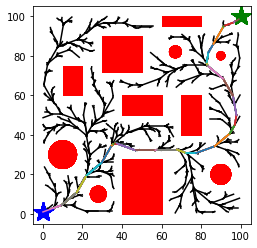

In [9]:
nn_RRT.showpath()

In [10]:
obst_vertex_x = [30, 30,50, 50, 
                 70, 70, 80, 80,  
                 40, 40, 60, 60,
                 40, 40, 60, 60, 
                 10, 10, 20, 20, 
                 60, 60, 80, 80] 
obst_vertex_y = [72,  90,  90, 72, 
                 40,  60,  60, 40,
                 50,  60,  60, 50,
                  0,  28,  28,  0,
                 60,  75,  75, 60,
                 95, 100, 100, 95]

In [11]:
def visualize_wheels(vc,wc):
    """
    Given the list of platform centre velocities(v,w) visualize the trajectories of:
    1. platform centre
    2. left wheel
    3. right wheel
    
    Save the wheel trajectories in the same manner that we saved the snapshots of the RRT tree above.
    """
    
    isExist = os.path.exists("nonholonomic_wheel")
    if not isExist:

      # Create a new directory because it does not exist 
        os.makedirs("nonholonomic_wheel")
        print("The new directory is created!")
    nn_RRT.clearFiles("nonholonomic_wheel")
        
        
    dist_w_c = 2
    pc_x = []
    pc_y = []
    theta = []
    lw_x = []
    lw_y = []
    rw_x = []
    rw_y = []
    lw_v = []
    rw_v = []
    pc_x.append(start_config[0])
    pc_y.append(start_config[1])
    theta.append(start_config[2])
    lw_x.append(start_config[0])
    lw_y.append(start_config[1]+dist_w_c)
    rw_x.append(start_config[0])
    rw_y.append(start_config[1]-dist_w_c)
    #Initialise the velocities
    for i in range(len(vc)):
        l_v = vc[i] - dist_w_c*wc[i]
        r_v = vc[i] + dist_w_c*wc[i]
        lw_v.append(l_v)
        rw_v.append(r_v)
    for i in range(len(lw_v)):
        th = theta[len(theta)-1] + wc[i]*dt
        theta.append(th)
        c_x = pc_x[len(pc_x)-1] + vc[i]*math.cos(th)*dt
        pc_x.append(c_x)
        l_x = c_x - dist_w_c*math.sin(th)
        lw_x.append(l_x)
        r_x = c_x + dist_w_c*math.sin(th)
        rw_x.append(r_x)
        c_y = pc_y[len(pc_y)-1] + vc[i]*math.sin(th)*dt
        pc_y.append(c_y)
        l_y = c_y + dist_w_c*math.cos(th)
        lw_y.append(l_y)
        r_y = c_y - dist_w_c*math.cos(th)
        rw_y.append(r_y)
        
    for j in range(len(lw_x)):
        plt.plot(goal[0],goal[1],'g*',markersize=20)
        plt.plot(start_config[0],start_config[1],'b*',markersize=20)
        for i in range(1,7): 
            x = obst_vertex_x[4*(i-1)]
            y = obst_vertex_y[4*(i-1)]
            width = obst_vertex_x[4*(i-1)+2] - obst_vertex_x[4*(i-1)]
            height = obst_vertex_y[4*(i-1)+2] - obst_vertex_y[4*(i-1)]
            rect = plt.Rectangle((x,y),width,height,linewidth=1,color='r')
            plt.gca().add_patch(rect)
           
        #centre positions of circular obstacles
        circle_x = [10, 90, 67, 90, 28]
        circle_y = [30, 80, 82, 20, 10]
        radii = [7, 2, 3, 5,4]


        for i in range(5): #plotting  circles
            circle = plt.Circle((circle_x[i],circle_y[i]),radii[i], color='r')
            plt.gca().add_patch(circle)

        #Plot Left Wheel
        Xl_wheel = lw_x[:j]
        Xr_wheel = rw_x[:j]
        Yl_wheel = lw_y[:j]
        Yr_wheel = rw_y[:j]
        Xc_wheel = pc_x[:j]
        Yc_wheel = pc_y[:j]
        plt.plot(Xl_wheel,Yl_wheel,'g')
        plt.plot(Xr_wheel,Yr_wheel,'g')
        plt.plot(Xc_wheel,Yc_wheel,'b')
        plt.legend(["goal","init pos","left-wheel","right-wheel","center"])
        plt.gca().set_aspect('equal', adjustable='box')
        name = f'nonholonomic_wheel/snap{str(j)}.png'
        plt.savefig(name,dpi=250)
        plt.show()
    
        
    plt.show()

The new directory is created!


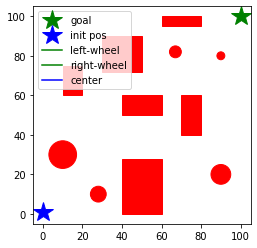

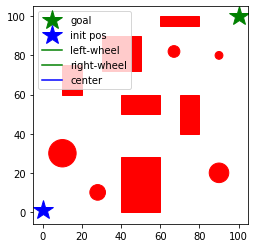

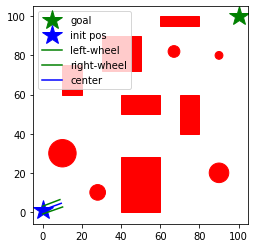

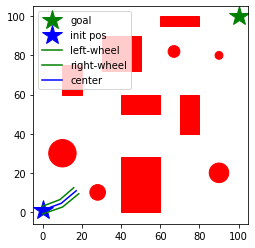

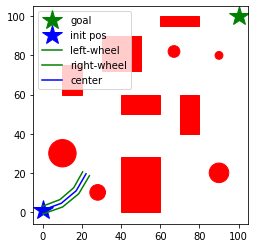

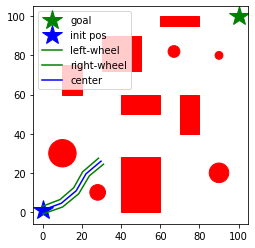

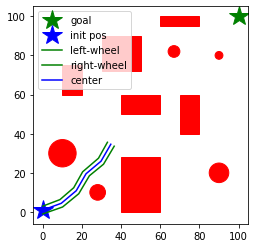

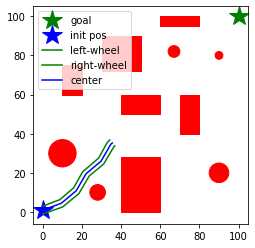

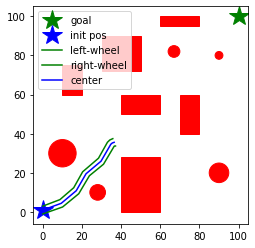

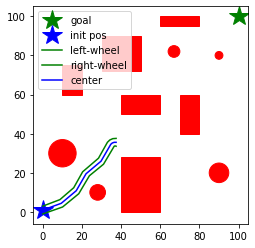

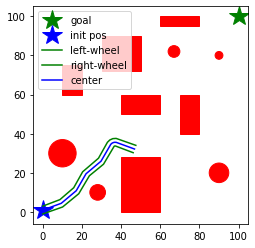

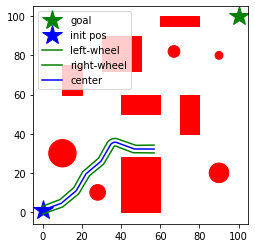

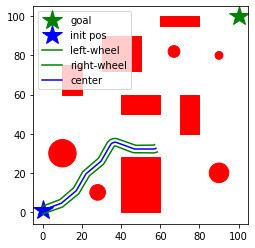

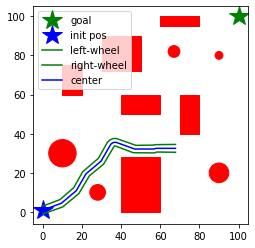

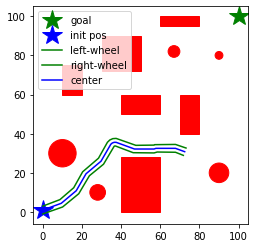

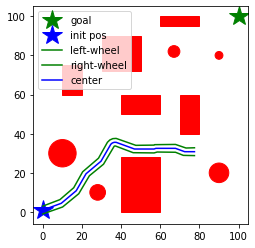

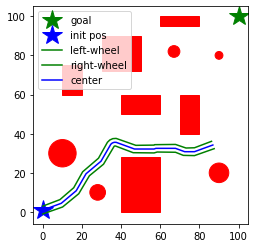

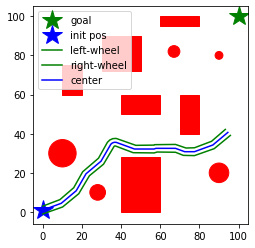

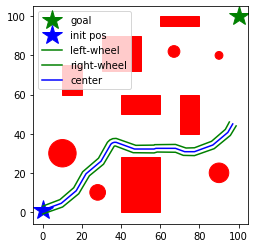

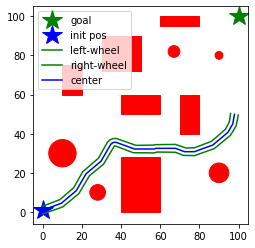

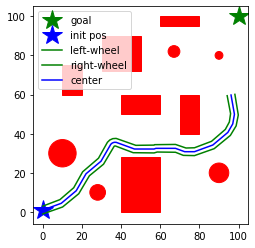

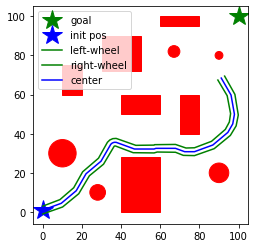

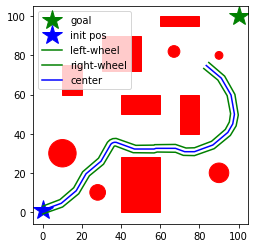

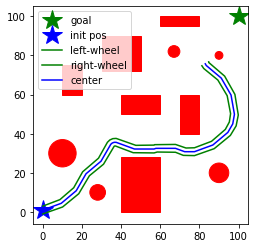

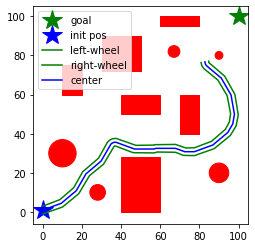

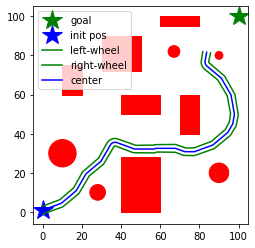

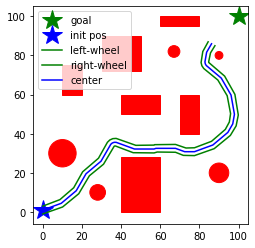

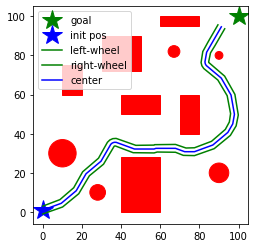

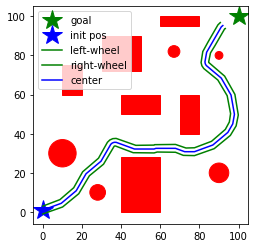

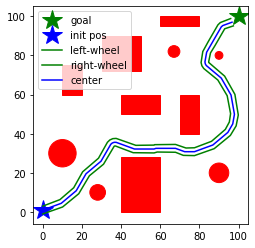

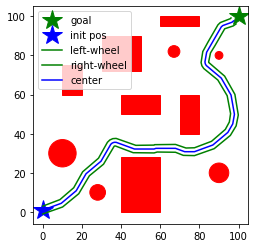

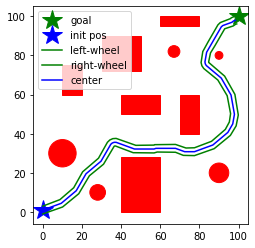

In [12]:
visualize_wheels(centre_v,w_list)